In [15]:
# this function does Spline smoothing with fill holes in the data.
from numpy import *
from pylab import *
import scipy.optimize.lbfgsb as lbfgsb
import numpy.linalg
from scipy.fftpack.realtransforms import dct,idct
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

def smoothn(y,nS0=10,axis=None,smoothOrder=2.0,sd=None,verbose=False,\
	s0=None,z0=None,isrobust=False,W=None,s=None,MaxIter=100,TolZ=1e-3,weightstr='bisquare'):
    '''
    function [z,s,exitflag,Wtot] = smoothn(varargin)

    SMOOTHN Robust spline smoothing for 1-D to N-D data.
    SMOOTHN provides a fast, automatized and robust discretized smoothing
    spline for data of any dimension.

    Z = SMOOTHN(Y) automatically smoothes the uniformly-sampled array Y. Y
    can be any N-D noisy array (time series, images, 3D data,...). Non
    finite data (NaN or Inf) are treated as missing values.

    Z = SMOOTHN(Y,S) smoothes the array Y using the smoothing parameter S.
    S must be a real positive scalar. The larger S is, the smoother the
    output will be. If the smoothing parameter S is omitted (see previous
    option) or empty (i.e. S = []), it is automatically determined using
    the generalized cross-validation (GCV) method.

    Z = SMOOTHN(Y,W) or Z = SMOOTHN(Y,W,S) specifies a weighting array W of
    real positive values, that must have the same size as Y. Note that a
    nil weight corresponds to a missing value.

    Robust smoothing
    ----------------
    Z = SMOOTHN(...,'robust') carries out a robust smoothing that minimizes
    the influence of outlying data.

    [Z,S] = SMOOTHN(...) also returns the calculated value for S so that
    you can fine-tune the smoothing subsequently if needed.

    An iteration process is used in the presence of weighted and/or missing
    values. Z = SMOOTHN(...,OPTION_NAME,OPTION_VALUE) smoothes with the
    termination parameters specified by OPTION_NAME and OPTION_VALUE. They
    can contain the following criteria:
    -----------------
    TolZ:       Termination tolerance on Z (default = 1e-3)
               TolZ must be in ]0,1[
    MaxIter:    Maximum number of iterations allowed (default = 100)
    Initial:    Initial value for the iterative process (default =
               original data)
    -----------------
    Syntax: [Z,...] = SMOOTHN(...,'MaxIter',500,'TolZ',1e-4,'Initial',Z0);

    [Z,S,EXITFLAG] = SMOOTHN(...) returns a boolean value EXITFLAG that
    describes the exit condition of SMOOTHN:
    1       SMOOTHN converged.
    0       Maximum number of iterations was reached.

    Class Support
    -------------
    Input array can be numeric or logical. The returned array is of class
    double.

    Notes
    -----
    The N-D (inverse) discrete cosine transform functions <a
    href="matlab:web('http://www.biomecardio.com/matlab/dctn.html')"
    >DCTN</a> and <a
    href="matlab:web('http://www.biomecardio.com/matlab/idctn.html')"
    >IDCTN</a> are required.

    To be made
    ----------
    Estimate the confidence bands (see Wahba 1983, Nychka 1988).

    Reference
    --------- 
    Garcia D, Robust smoothing of gridded data in one and higher dimensions
    with missing values. Computational Statistics & Data Analysis, 2010. 
    <a
    href="matlab:web('http://www.biomecardio.com/pageshtm/publi/csda10.pdf')">PDF download</a>

    Examples:
    --------
    # 1-D example
    x = linspace(0,100,2**8);
    y = cos(x/10)+(x/50)**2 + randn(size(x))/10;
    y[[70, 75, 80]] = [5.5, 5, 6];
    z = smoothn(y); # Regular smoothing
    zr = smoothn(y,'robust'); # Robust smoothing
    subplot(121), plot(x,y,'r.',x,z,'k','LineWidth',2)
    axis square, title('Regular smoothing')
    subplot(122), plot(x,y,'r.',x,zr,'k','LineWidth',2)
    axis square, title('Robust smoothing')

    # 2-D example
    xp = 0:.02:1;
    [x,y] = meshgrid(xp);
    f = exp(x+y) + sin((x-2*y)*3);
    fn = f + randn(size(f))*0.5;
    fs = smoothn(fn);
    subplot(121), surf(xp,xp,fn), zlim([0 8]), axis square
    subplot(122), surf(xp,xp,fs), zlim([0 8]), axis square

    # 2-D example with missing data
    n = 256;
    y0 = peaks(n);
    y = y0 + rand(size(y0))*2;
    I = randperm(n^2);
    y(I(1:n^2*0.5)) = NaN; # lose 1/2 of data
    y(40:90,140:190) = NaN; # create a hole
    z = smoothn(y); # smooth data
    subplot(2,2,1:2), imagesc(y), axis equal off
    title('Noisy corrupt data')
    subplot(223), imagesc(z), axis equal off
    title('Recovered data ...')
    subplot(224), imagesc(y0), axis equal off
    title('... compared with original data')

    # 3-D example
    [x,y,z] = meshgrid(-2:.2:2);
    xslice = [-0.8,1]; yslice = 2; zslice = [-2,0];
    vn = x.*exp(-x.^2-y.^2-z.^2) + randn(size(x))*0.06;
    subplot(121), slice(x,y,z,vn,xslice,yslice,zslice,'cubic')
    title('Noisy data')
    v = smoothn(vn);
    subplot(122), slice(x,y,z,v,xslice,yslice,zslice,'cubic')
    title('Smoothed data')

    # Cardioid
    t = linspace(0,2*pi,1000);
    x = 2*cos(t).*(1-cos(t)) + randn(size(t))*0.1;
    y = 2*sin(t).*(1-cos(t)) + randn(size(t))*0.1;
    z = smoothn(complex(x,y));
    plot(x,y,'r.',real(z),imag(z),'k','linewidth',2)
    axis equal tight

    # Cellular vortical flow
    [x,y] = meshgrid(linspace(0,1,24));
    Vx = cos(2*pi*x+pi/2).*cos(2*pi*y);
    Vy = sin(2*pi*x+pi/2).*sin(2*pi*y);
    Vx = Vx + sqrt(0.05)*randn(24,24); # adding Gaussian noise
    Vy = Vy + sqrt(0.05)*randn(24,24); # adding Gaussian noise
    I = randperm(numel(Vx));
    Vx(I(1:30)) = (rand(30,1)-0.5)*5; # adding outliers
    Vy(I(1:30)) = (rand(30,1)-0.5)*5; # adding outliers
    Vx(I(31:60)) = NaN; # missing values
    Vy(I(31:60)) = NaN; # missing values
    Vs = smoothn(complex(Vx,Vy),'robust'); # automatic smoothing
    subplot(121), quiver(x,y,Vx,Vy,2.5), axis square
    title('Noisy velocity field')
    subplot(122), quiver(x,y,real(Vs),imag(Vs)), axis square
    title('Smoothed velocity field')

    See also SMOOTH, SMOOTH3, DCTN, IDCTN.

    -- Damien Garcia -- 2009/03, revised 2010/11
    Visit my <a
    href="matlab:web('http://www.biomecardio.com/matlab/smoothn.html')">website</a> for more details about SMOOTHN 

    # Check input arguments
    error(nargchk(1,12,nargin));

    z0=None,W=None,s=None,MaxIter=100,TolZ=1e-3
    '''
    if type(y) == ma.core.MaskedArray:  # masked array
        is_masked = True
        mask = y.mask
        y = np.array(y)
        y[mask] = 0.
        if W != None:
            W  = np.array(W)
            W[mask] = 0.
        if sd != None:
            W = np.array(1./sd**2)
            W[mask] = 0.
            sd = None
        y[mask] = np.nan

    if sd != None:
        sd_ = np.array(sd)
        mask = (sd > 0.)
        W = np.zeros_like(sd_)
        W[mask] = 1./sd_[mask]**2
        sd = None

    if W != None:
        W = W/W.max()

    sizy = y.shape;

    # sort axis
    if axis == None:
        axis = tuple(np.arange(y.ndim))

    noe = y.size # number of elements
    if noe<2:
        z = y
        exitflag = 0;Wtot=0
        return z,s,exitflag,Wtot
    #---
    # Smoothness parameter and weights
    #if s != None:
    #  s = []
    if W == None:
        W = ones(sizy);

    #if z0 == None:
    #  z0 = y.copy()

    #---
    # "Weighting function" criterion
    weightstr = weightstr.lower()
    #---
    # Weights. Zero weights are assigned to not finite values (Inf or NaN),
    # (Inf/NaN values = missing data).
    IsFinite = np.array(isfinite(y)).astype(bool);
    nof = IsFinite.sum() # number of finite elements
    W = W*IsFinite;
    if any(W<0):
        error('smoothn:NegativeWeights',\
                    'Weights must all be >=0')
    else:
        #W = W/np.max(W)
        pass
    #---
    # Weighted or missing data?
    isweighted = any(W != 1);
    #---
    # Robust smoothing?
    #isrobust
    #---
    # Automatic smoothing?
    isauto = not s;
    #---
    # DCTN and IDCTN are required
    try:
        from scipy.fftpack.realtransforms import dct,idct
    except:
        z = y
        exitflag = -1;Wtot=0
        return z,s,exitflag,Wtot

    ## Creation of the Lambda tensor
    #---
    # Lambda contains the eingenvalues of the difference matrix used in this
    # penalized least squares process.
    axis = tuple(np.array(axis).flatten())
    d =  y.ndim;
    Lambda = zeros(sizy);
    for i in axis:
    # create a 1 x d array (so e.g. [1,1] for a 2D case
        siz0 = ones((1,y.ndim))[0];
        siz0[i] = sizy[i];
    # cos(pi*(reshape(1:sizy(i),siz0)-1)/sizy(i)))
    # (arange(1,sizy[i]+1).reshape(siz0) - 1.)/sizy[i]
        Lambda = Lambda + (cos(pi*(arange(1,sizy[i]+1) - 1.)/sizy[i]).reshape(siz0))
    #else:
    #  Lambda = Lambda + siz0
    Lambda = -2.*(len(axis)-Lambda);
    if not isauto:
        Gamma = 1./(1+(s*abs(Lambda))**smoothOrder);

    ## Upper and lower bound for the smoothness parameter
    # The average leverage (h) is by definition in [0 1]. Weak smoothing occurs
    # if h is close to 1, while over-smoothing appears when h is near 0. Upper
    # and lower bounds for h are given to avoid under- or over-smoothing. See
    # equation relating h to the smoothness parameter (Equation #12 in the
    # referenced CSDA paper).
    N = sum(array(sizy) != 1); # tensor rank of the y-array
    hMin = 1e-6; hMax = 0.99;
    # (h/n)**2 = (1 + a)/( 2 a)
    # a = 1/(2 (h/n)**2 -1) 
    # where a = sqrt(1 + 16 s)
    # (a**2 -1)/16
    try:
        sMinBnd = np.sqrt((((1+sqrt(1+8*hMax**(2./N)))/4./hMax**(2./N))**2-1)/16.);
        sMaxBnd = np.sqrt((((1+sqrt(1+8*hMin**(2./N)))/4./hMin**(2./N))**2-1)/16.);
    except:
        sMinBnd = None
        sMaxBnd = None
    ## Initialize before iterating
    #---
    Wtot = W;
    #--- Initial conditions for z
    if isweighted:
        #--- With weighted/missing data
        # An initial guess is provided to ensure faster convergence. For that
        # purpose, a nearest neighbor interpolation followed by a coarse
        # smoothing are performed.
        #---
        if z0 != None: # an initial guess (z0) has been provided
            z = z0;
        else:
            z = y #InitialGuess(y,IsFinite);
            z[~IsFinite] = 0.
    else:
        z = zeros(sizy);
    #---
    z0 = z;
    y[~IsFinite] = 0; # arbitrary values for missing y-data
    #---
    tol = 1.;
    RobustIterativeProcess = True;
    RobustStep = 1;
    nit = 0;
    #--- Error on p. Smoothness parameter s = 10^p
    errp = 0.1;
    #opt = optimset('TolX',errp);
    #--- Relaxation factor RF: to speedup convergence
    RF = 1 + 0.75*isweighted;
    # ??
    ## Main iterative process
    #---
    if isauto:
        try:
            xpost = array([(0.9*log10(sMinBnd) + log10(sMaxBnd)*0.1)])
        except:
            array([100.])
    else:
        xpost = array([log10(s)])
    while RobustIterativeProcess:
        #--- "amount" of weights (see the function GCVscore)
        aow = sum(Wtot)/noe; # 0 < aow <= 1
        #---
        while tol>TolZ and nit<MaxIter:
            if verbose:
                print 'tol',tol,'nit',nit
            nit = nit+1;
            DCTy = dctND(Wtot*(y-z)+z,f=dct);
            if isauto and not remainder(log2(nit),1):
                #---
                # The generalized cross-validation (GCV) method is used.
                # We seek the smoothing parameter s that minimizes the GCV
                # score i.e. s = Argmin(GCVscore).
                # Because this process is time-consuming, it is performed from
                # time to time (when nit is a power of 2)
                #---
                # errp in here somewhere

                #xpost,f,d = lbfgsb.fmin_l_bfgs_b(gcv,xpost,fprime=None,factr=10.,\
                #   approx_grad=True,bounds=[(log10(sMinBnd),log10(sMaxBnd))],\
                #   args=(Lambda,aow,DCTy,IsFinite,Wtot,y,nof,noe))

                # if we have no clue what value of s to use, better span the
                # possible range to get a reasonable starting point ...
                # only need to do it once though. nS0 is teh number of samples used
                if not s0:
                    ss = np.arange(nS0)*(1./(nS0-1.))*(log10(sMaxBnd)-log10(sMinBnd))+ log10(sMinBnd)
                    g = np.zeros_like(ss)
                    for i,p in enumerate(ss):
                        g[i] = gcv(p,Lambda,aow,DCTy,IsFinite,Wtot,y,nof,noe,smoothOrder)
                        #print 10**p,g[i]
                    xpost = [ss[g==g.min()]]
                    #print '==============='
                    #print nit,tol,g.min(),xpost[0],s
                    #print '==============='
                else:
                    xpost = [s0]
                xpost,f,d = lbfgsb.fmin_l_bfgs_b(gcv,xpost,fprime=None,factr=10.,\
                   approx_grad=True,bounds=[(log10(sMinBnd),log10(sMaxBnd))],\
                   args=(Lambda,aow,DCTy,IsFinite,Wtot,y,nof,noe,smoothOrder))
            s = 10**xpost[0];
            # update the value we use for the initial s estimate
            s0 = xpost[0]

            Gamma = 1./(1+(s*abs(Lambda))**smoothOrder);

            z = RF*dctND(Gamma*DCTy,f=idct) + (1-RF)*z;
            # if no weighted/missing data => tol=0 (no iteration)
            tol = isweighted*norm(z0-z)/norm(z);

            z0 = z; # re-initialization
        exitflag = nit<MaxIter;

        if isrobust: #-- Robust Smoothing: iteratively re-weighted process
            #--- average leverage
            h = sqrt(1+16.*s); 
            h = sqrt(1+h)/sqrt(2)/h; 
            h = h**N;
            #--- take robust weights into account
            Wtot = W*RobustWeights(y-z,IsFinite,h,weightstr);
            #--- re-initialize for another iterative weighted process
            isweighted = True; tol = 1; nit = 0; 
            #---
            RobustStep = RobustStep+1;
            RobustIterativeProcess = RobustStep<3; # 3 robust steps are enough.
        else:
            RobustIterativeProcess = False; # stop the whole process

    ## Warning messages
    #---
    if isauto:
        if abs(log10(s)-log10(sMinBnd))<errp:
            warning('MATLAB:smoothn:SLowerBound',\
                ['s = %.3f '%(s) + ': the lower bound for s '\
                + 'has been reached. Put s as an input variable if required.'])
        elif abs(log10(s)-log10(sMaxBnd))<errp:
            warning('MATLAB:smoothn:SUpperBound',\
                ['s = %.3f '%(s) + ': the upper bound for s '\
                + 'has been reached. Put s as an input variable if required.'])
    #warning('MATLAB:smoothn:MaxIter',\
    #    ['Maximum number of iterations (%d'%(MaxIter) + ') has '\
    #    + 'been exceeded. Increase MaxIter option or decrease TolZ value.'])
    return z,s,exitflag,Wtot

def warning(s1,s2):
    print s1
    print s2[0]

## GCV score
#---
#function GCVscore = gcv(p)
def gcv(p,Lambda,aow,DCTy,IsFinite,Wtot,y,nof,noe,smoothOrder):
    # Search the smoothing parameter s that minimizes the GCV score
    #---
    s = 10**p;
    Gamma = 1./(1+(s*abs(Lambda))**smoothOrder);
    #--- RSS = Residual sum-of-squares
    if aow>0.9: # aow = 1 means that all of the data are equally weighted
        # very much faster: does not require any inverse DCT
        RSS = norm(DCTy*(Gamma-1.))**2;
    else:
        # take account of the weights to calculate RSS:
        yhat = dctND(Gamma*DCTy,f=idct);
        RSS = norm(sqrt(Wtot[IsFinite])*(y[IsFinite]-yhat[IsFinite]))**2;
    #---
    TrH = sum(Gamma);
    GCVscore = RSS/float(nof)/(1.-TrH/float(noe))**2;
    return GCVscore

## Robust weights
#function W = RobustWeights(r,I,h,wstr)
def RobustWeights(r,I,h,wstr):
    # weights for robust smoothing.
    MAD = median(abs(r[I]-median(r[I]))); # median absolute deviation
    u = abs(r/(1.4826*MAD)/sqrt(1-h)); # studentized residuals
    if wstr == 'cauchy':
        c = 2.385; W = 1./(1+(u/c)**2); # Cauchy weights
    elif wstr == 'talworth':
        c = 2.795; W = u<c; # Talworth weights
    else:
        c = 4.685; W = (1-(u/c)**2)**2.*((u/c)<1); # bisquare weights

    W[isnan(W)] = 0;
    return W

## Initial Guess with weighted/missing data
#function z = InitialGuess(y,I)
def InitialGuess(y,I):
    #-- nearest neighbor interpolation (in case of missing values)
    if any(~I):
        try:
            from scipy.ndimage.morphology import distance_transform_edt
            #if license('test','image_toolbox')
            #[z,L] = bwdist(I);
            L = distance_transform_edt(1-I)
            z = y;
            z[~I] = y[L[~I]];
        except:
            # If BWDIST does not exist, NaN values are all replaced with the
            # same scalar. The initial guess is not optimal and a warning
            # message thus appears.
            z = y;
            z[~I] = mean(y[I]);
    else:
        z = y;
    # coarse fast smoothing
    z = dctND(z,f=dct)
    k = array(z.shape)
    m = ceil(k/10)+1
    d = []
    for i in xrange(len(k)):
        d.append(arange(m[i],k[i]))
    d = np.array(d).astype(int)
    z[d] = 0.
    z = dctND(z,f=idct)
    return z
    #-- coarse fast smoothing using one-tenth of the DCT coefficients
    #siz = z.shape;
    #z = dct(z,norm='ortho',type=2);
    #for k in np.arange(len(z.shape)):
    #    z[ceil(siz[k]/10)+1:-1] = 0;
    #    ss = tuple(roll(array(siz),1-k))
    #    z = z.reshape(ss)
    #    z = np.roll(z.T,1)
    #z = idct(z,norm='ortho',type=2);


# NB: filter is 2*I - (np.roll(I,-1) + np.roll(I,1))


def dctND(data,f=dct):
    nd = len(data.shape)
    if nd == 1:
        return f(data,norm='ortho',type=2)
    elif nd == 2:
        return f(f(data,norm='ortho',type=2).T,norm='ortho',type=2).T
    elif nd ==3:
        return f(f(f(data,norm='ortho',type=2,axis=0)\
                         ,norm='ortho',type=2,axis=1)\
                         ,norm='ortho',type=2,axis=2)

def peaks(n):
    '''
    Mimic basic of matlab peaks fn
    '''
    xp = arange(n)
    [x,y] = meshgrid(xp,xp)
    z = np.zeros_like(x).astype(float)
    for i in xrange(n/5):
        x0 = random()*n
        y0 = random()*n
        sdx = random()*n/4.
        sdy = sdx
        c = random()*2 - 1.
        f = exp(-((x-x0)/sdx)**2-((y-y0)/sdy)**2 - (((x-x0)/sdx))*((y-y0)/sdy)*c)
        #f /= f.sum()
        f *= random()
        z += f
    return z 

def test1():
    plt.figure()
    plt.clf()
    # 1-D example
    x = linspace(0,100,2**8);
    y = cos(x/10)+(x/50)**2 + randn(size(x))/10;
    y[[70, 75, 80]] = [5.5, 5, 6];
    z = smoothn(y)[0]; # Regular smoothing
    zr = smoothn(y,isrobust=True)[0]; # Robust smoothing
    subplot(121)
    plot(x,y,'r.')
    plot(x,z,'k')
    title('Regular smoothing')
    subplot(122)
    plot(x,y,'r.')
    plot(x,zr,'k')
    title('Robust smoothing')

def test2(axis=None):
    # 2-D example
    plt.figure(2)
    plt.clf()
    xp = arange(0,1,.02)
    [x,y] = meshgrid(xp,xp);
    f = exp(x+y) + sin((x-2*y)*3);
    fn = f + (randn(f.size)*0.5).reshape(f.shape);
    fs = smoothn(fn,axis=axis)[0];
    subplot(121); plt.imshow(fn,interpolation='Nearest');# axis square
    subplot(122); plt.imshow(fs,interpolation='Nearest'); # axis square

def test3(axis=None):
    # 2-D example with missing data
    plt.figure(3)
    plt.clf()
    n = 256;
    y0 = peaks(n);
    y = (y0 + random(shape(y0))*2 - 1.0).flatten();
    I = np.random.permutation(range(n**2));
    y[I[1:n**2*0.5]] = nan; # lose 50% of data
    y = y.reshape(y0.shape)
    y[40:90,140:190] = nan; # create a hole
    yData = y.copy()
    z0,s,exitflag,Wtot = smoothn(yData,axis=axis); # smooth data
    yData = y.copy()
    z,s,exitflag,Wtot = smoothn(yData,isrobust=True,axis=axis); # smooth data
    y = yData
    vmin = np.min([np.min(z),np.min(z0),np.min(y),np.min(y0)])
    vmax = np.max([np.max(z),np.max(z0),np.max(y),np.max(y0)])
    subplot(221); plt.imshow(y,interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('Noisy corrupt data')
    subplot(222); plt.imshow(z0,interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('Recovered data #1')
    subplot(223); plt.imshow(z,interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('Recovered data #2')
    subplot(224); plt.imshow(y0,interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('... compared with original data')

def test4(i=10,step=0.2,axis=None):
    [x,y,z] = mgrid[-2:2:step,-2:2:step,-2:2:step]
    x = array(x);y=array(y);z=array(z)
    xslice = [-0.8,1]; yslice = 2; zslice = [-2,0];
    v0 = x*exp(-x**2-y**2-z**2)
    vn = v0 + randn(x.size).reshape(x.shape)*0.06
    v = smoothn(vn)[0];
    plt.figure(4)
    plt.clf()
    vmin = np.min([np.min(v[:,:,i]),np.min(v0[:,:,i]),np.min(vn[:,:,i])])
    vmax = np.max([np.max(v[:,:,i]),np.max(v0[:,:,i]),np.max(vn[:,:,i])])
    subplot(221); plt.imshow(v0[:,:,i],interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('clean z=%d'%i)
    subplot(223); plt.imshow(vn[:,:,i],interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('noisy')
    subplot(224); plt.imshow(v[:,:,i],interpolation='Nearest',vmin=vmin,vmax=vmax);
    title('cleaned')


def test5():
    t = linspace(0,2*pi,1000);
    x = 2*cos(t)*(1-cos(t)) + randn(size(t))*0.1;
    y = 2*sin(t)*(1-cos(t)) + randn(size(t))*0.1;
    zx = smoothn(x)[0];
    zy = smoothn(y)[0];
    plt.figure(5)
    plt.clf()
    plt.title('Cardioid')
    plot(x,y,'r.')
    plot(zx,zy,'k')

def test6(noise=0.05,nout=30):
    plt.figure(6)
    plt.clf()
    [x,y] = meshgrid(linspace(0,1,24),linspace(0,1,24))
    Vx0 = cos(2*pi*x+pi/2)*cos(2*pi*y);
    Vy0 = sin(2*pi*x+pi/2)*sin(2*pi*y);
    Vx = Vx0 + noise*randn(24,24); # adding Gaussian noise
    Vy = Vy0 + noise*randn(24,24); # adding Gaussian noise
    I = np.random.permutation(range(Vx.size))
    Vx = Vx.flatten()
    Vx[I[0:nout]] = (rand(nout,1)-0.5)*5; # adding outliers
    Vx = Vx.reshape(Vy.shape)
    Vy = Vy.flatten()
    Vy[I[0:nout]] = (rand(nout,1)-0.5)*5; # adding outliers
    Vy = Vy.reshape(Vx.shape)
    Vsx = smoothn(Vx,isrobust=True)[0];
    Vsy = smoothn(Vy,isrobust=True)[0];
    subplot(131);quiver(x,y,Vx,Vy,2.5)
    title('Noisy')
    subplot(132); quiver(x,y,Vsx,Vsy) 
    title('Recovered')
    subplot(133); quiver(x,y,Vx0,Vy0)          
    title('Original')

def sparseSVD(D):
    import scipy.sparse
    try:
        import sparsesvd
    except:
        print 'bummer ... better get sparsesvd'
        exit(0)
    Ds = scipy.sparse.csc_matrix(D)
    a = sparsesvd.sparsesvd(Ds,Ds.shape[0])
    return a

def sparseTest(n=1000):
    I = np.identity(n)

    # define a 'traditional' D1 matrix
    # which is a right-side difference
    # and which is *not* symmetric :-( 
    D1 = np.matrix(I - np.roll(I,1))
    # so define a symemtric version
    D1a = D1.T - D1
    import scipy.linalg
    U, s, Vh = scipy.linalg.svd(D1a)

    # now, get eigenvectors for D1a
    Ut,eigenvalues,Vt = sparseSVD(D1a)
    Ut = np.matrix(Ut)


    # then, an equivalent 2nd O term would be
    D2a = D1a**2

    # show we can recover D1a
    D1a_est = Ut.T * np.diag(eigenvalues) * Ut


    # Now, because D2a (& the target D1a) are symmetric:
    D1a_est = Ut.T * np.diag(eigenvalues**0.5) * Ut


    D = 2*I - (np.roll(I,-1) + np.roll(I,1))
    a = sparseSVD(-D)
    eigenvalues = np.matrix(a[1])
    Ut = np.matrix(a[0])
    Vt = np.matrix(a[2])
    orig = (Ut.T * np.diag(np.array(eigenvalues).flatten()) * Vt)

    Feigenvalues = np.diag(np.array(np.c_[eigenvalues,0]).flatten())
    FUt = np.c_[Ut.T,np.zeros(Ut.shape[1])]
    # confirm: FUt * Feigenvalues * FUt.T ~= D


    # m is a 1st O difference matrix
    # with careful edge conditions
    # such that m.T * m = D2
    # D2 being a 2nd O difference matrix
    m = np.matrix(np.identity(100) - np.roll(np.identity(100),1))
    m[-1,-1] = 0
    m[0,0] = 1
    a = sparseSVD(m)
    eigenvalues = np.matrix(a[1])
    Ut = np.matrix(a[0])
    Vt = np.matrix(a[2])
    orig = (Ut.T * np.diag(np.array(eigenvalues).flatten()) * Vt)
    # Vt* Vt.T = I
    # Ut.T * Ut = I
    # ((Vt.T * (np.diag(np.array(eigenvalues).flatten())**2)) * Vt)
    # we see you get the same as m.T * m by squaring the eigenvalues


C:\Users\kew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:255: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


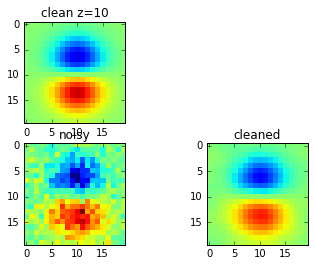

In [17]:
test4()

In [3]:
% matplotlib inline

In [1]:
print 1

1
